# Подготовка данных и обучение нейронных сетей:

In [4]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import torch, torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
import torchvision.utils as vutils
from torchvision import transforms, models
import cv2
from bs4 import BeautifulSoup
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import shutil

In [5]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

# Код для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

# Реализуем обучение нейронной сети, выполняющей детектирование объектов класса "person"

Имеется заранее размеченный датасет. Закачать можно по этой [ссылке](https://disk.yandex.ru/d/7HNoc81at3r6VQ)

Реализуем аугментацию данных, увеличив датасет вдвое. Для этого написал кастомную функцию aug:

In [6]:
from augmentation import *
aug(out_folder='augmented_dataset')

Исходное число фотографий и аннотаций = 500
Итоговое число фотографий и аннотаций = 1000


___

## Преподготовка данных для обучения сети Faster RCNN:

Разделим данные на тренировочные и тестовые:

In [7]:
# Получим имена файлов без значения кодировки
names = []
for file in os.listdir('augmented_dataset/images'):
    names.append(file.split('.')[0])

Рандомно поделим фотографии на train (80%) и test (20%)

In [8]:
train_data = random.sample(names, int(len(names) * 0.8))
print(f'Число изображений на train = {len(train_data)}')
test_data = list(set(names) - set(train_data))
print(f'Число изображений на test = {len(test_data)}')

Число изображений на train = 800
Число изображений на test = 200


В файле data_analysis.ipynb мы поработали с данными в формате json. Теперь рассмотрим как работать работать с аналогичными данными, но представленными в формате xml

In [9]:
with open('detect_dataset/annotations/PASCAL_VOC_xml/oz7_violation_frame519.xml') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
print(objects)

[<object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1000.3</xmin>
<ymin>301.6</ymin>
<xmax>1082.3</xmax>
<ymax>514.5</ymax>
</bndbox>
</object>, <object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1140.9</xmin>
<ymin>260.36</ymin>
<xmax>1215.6</xmax>
<ymax>493.2</ymax>
</bndbox>
</object>]


В данном случае информативная информация представлена в разделе _xmin_, _ymin_, _xmax_, _ymax_ и сам класс представлен в разделе _name_

In [10]:
# Создадим функции, которые как раз распарсят эти данные:
def generate_box(obj):
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    return [xmin, ymin, xmax, ymax]

'''
класс человек - 1
p.s:
    Я заранее прописал условия номеров классов
    для обучении следующей сети с двумя классами:
      1 -  человек с каской
      2 -  человек без каски
'''
def generate_label(obj):
    if (obj.find('name').text == "person") or (obj.find('name').text == "hat"):
        return 1
    elif obj.find('name').text == "no_hat":
        return 2   
    return 0

Pytorch как раз при обучении для моделей детекции тредует данные в формате [xmin, ymin, xmax, ymax] для каждого бокса

In [11]:
'''
Эта функция будет выдавать на выходе словарь с 3 ключами: boxes, labels и image_id.
На вход функция принимает:
image_id - индекс фотки из Dataset класса Pytorch 
file - путь к xml файлу
'''
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)

        # Будем итерироваться по листу, полученному после раскрытия xml файла:
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # В данном случае всего 1 класс 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # переведем индекс торч тензор
        img_id = torch.tensor([image_id])

        # получим итоговый словарь для исследуемой фотографии
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [12]:
class MakeDataset(Dataset):
    def __init__(self, path, data, transforms=None):
        self.transforms = transforms
        self.names_list = data
        self.path = path

    def __getitem__(self, idx):
        name = self.names_list[idx]
        file_image = self.path + '/images/' + str(name) + '.jpg'
        file_label = self.path + '/annotations/' + str(name) + '.xml'
        img = Image.open(file_image).convert("RGB")

        #Сделаем словарь с аннотацией с помощью ранее написанной функции:
        target = generate_target(idx, file_label)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.names_list)

In [13]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

# На вход класса MakeDataset в __init__ подается значение списка файлов и 
# путь общей папке с аннотациями и изображениями:

train_dataset = MakeDataset(path='augmented_dataset', data=train_data, transforms=data_transform)
val_dataset = MakeDataset(path='augmented_dataset', data=test_data, transforms=data_transform)

Посмотрим в каком формате данные харнятся в классе Датасет:

In [14]:
first = train_dataset[6]
features, labels = first
print(labels)

{'boxes': tensor([[ 915.,  371., 1064.,  761.]]), 'labels': tensor([1]), 'image_id': tensor([6])}


В данном случае на фотке есть 2 объекта класса человек, поэтому 2 bounding бокса

In [15]:
def collate_fn(batch):  # Представляет значения в батчах как кортежи
    return tuple(zip(*batch)) 


batch_size = 5  # Зададим чило фотографий на 1 батч

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Демонстрация выходных данных в класса DataLoader

In [16]:
device = 'cpu'
for imgs, annotations in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 994.,  319., 1069.,  642.],
        [ 899.,  378., 1017.,  668.]]), 'labels': tensor([1, 1]), 'image_id': tensor([288])}, {'boxes': tensor([[ 973.,  319., 1083.,  615.],
        [ 873.,  361.,  993.,  611.]]), 'labels': tensor([1, 1]), 'image_id': tensor([71])}, {'boxes': tensor([[ 753.,  503.,  883.,  930.],
        [ 842.,  471., 1081.,  980.]]), 'labels': tensor([1, 1]), 'image_id': tensor([623])}, {'boxes': tensor([[678., 159., 711., 257.],
        [642., 162., 697., 274.]]), 'labels': tensor([1, 1]), 'image_id': tensor([597])}, {'boxes': tensor([[ 978.,  307., 1068.,  511.],
        [1017.,  268., 1078.,  373.]]), 'labels': tensor([1, 1]), 'image_id': tensor([218])}]


---

## Визуализируем исходные изображения: 

Возьмем случайные 2 фотки и изобразим их боксы:


In [17]:
def plot_random_images(train_data_loader):
    image_batch, label_batch = next(iter(train_data_loader))

    # Пройдемся в цикле по двум первым фоткам в рандомном батче:
    for i, image in enumerate(image_batch[0:2]):
        image = np.transpose(image, (1, 2, 0))
        img = image.numpy().copy() 
        img = (img * 255).astype(np.uint8)
        annot = label_batch[i]

        # Зададим наименования классов:
        class_detect = ['none','person']

        # Зададим цветовое отображение для классов:
        color_class = [(0,0,255), (0,255,0), (255,50,0)]

        # Пройдемся в цикле по всем боксам на изображении
        for j in range(annot['boxes'].size()[0]):
                [xmin, ymin, xmax, ymax] = annot['boxes'][j]
                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                n_class = int(annot['labels'][j])
                text = class_detect[n_class] 
                img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color_class[n_class], 2)
                img = cv2.putText(img, text, (xmin, ymin - 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 2, color_class[n_class], 3)
        plt.imshow(img)
        plt.show()

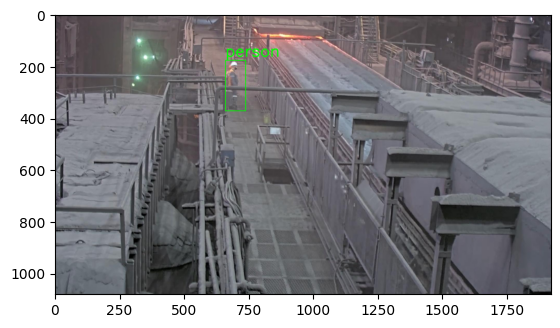

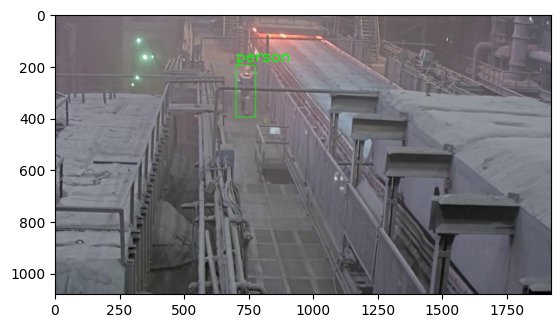

In [18]:
plot_random_images(train_data_loader)

---

## Конфигурация сети:

Будем использовать Transfer learning подход, обучая сеть Faster RCNN, которая была уже предобучена на COCO

In [22]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Заменим число выходных класссов на то, что нам нужно
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Зададим модель (число классов задал как n+1, так как пустой 0 класс)
model = get_model_instance_segmentation(2)

Внутри реализации Faster R-CNN с FPN (Feature Pyramid Network) в библиотеке PyTorch torchvision используется сложная функция потерь, которая объединяет несколько подфункций.


In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Будем обучать сети на видеокарте:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

device = 'cpu'
model.to(device)
num_epochs = 40  # число эпох обучения

cuda


В данном случае выбор оптимизатора SGD может быть обусловлен следующими причинами:

Размер и сложность модели: Faster R-CNN с ResNet50-FPN — это достаточно большая и сложная модель с множеством обучаемых параметров, что может привести к быстрому переобучению и нестабильности при использовании более сложных оптимизаторов, таких как Adam.
Количество и тип данных: при обучении объектных детекторов, основанных на Faster R-CNN, используется функция потерь, которая состоит из нескольких компонентов, включая компоненты, связанные с классификацией и регрессией объектов. SGD является классическим оптимизатором, который хорошо справляется с обучением таких моделей, в то время как Adam, который является более продвинутым методом, может не давать оптимальных результатов.
Наличие предобученных весов: в данном случае мы используем предобученные веса для Faster R-CNN с ResNet50-FPN, что может упростить процесс обучения и позволить использовать более простой оптимизатор SGD вместо Adam.

In [24]:
# Создадим пустую папку, в которую будем сохранять обученные модели
newpath = 'models'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [19]:
# Запустим прямо в ноутбуке TensorBoard:
%reload_ext tensorboard
%tensorboard --logdir 'results'

loss_dict представляет словарь, который содержит значения функции потерь для каждой из компонентов Faster R-CNN, используемых во время обучения. В частности, словарь loss_dict в модели Faster R-CNN включает следующие компоненты функции потерь:

1. Loss_objectness отвечает за определение, содержит ли регион предполагаемого объекта какой-либо объект или нет (бинарная классификация). Для этого loss_objectness использует бинарную кросс-энтропию между выходом сети и соответствующими метками для каждого региона.

2. Loss_classifier отвечает за определение, к какому классу принадлежит объект в данном регионе. Для этого loss_classifier использует многоклассовую кросс-энтропию между выходом сети и соответствующими метками классов для каждого региона.
3. Loss_box_reg отвечает за определение насколько хорошо модель прогнозирует корректные координаты ограничивающего прямоугольника (bounding box) для обнаруженного объекта на изображении. Для этого loss_box_reg использует среднеквадратичную ошибку между прогнозируемыми координатами ограничивающего прямоугольника и фактическими координатами.

4. Loss_rpn_box_reg отвечает за определение насколько хорошо модель прогнозирует координаты ограничивающего прямоугольника (bounding box) для регионов, полученных от Region Proposal Network (RPN), которые могут содержать объекты. Для этого loss_rpn_box_reg использует среднеквадратичную ошибку между прогнозируемыми координатами ограничивающего прямоугольника и фактическими координатами.

## Код обучения сети:

Загрузим кастомую функцию и проведем обучение сети:

In [20]:
from training_rcnn import *

train(model=model, train_data_loader=train_data_loader, optimizer=optimizer,
      val_data_loader=val_data_loader,
      num_epochs=30, comment=' person detection', device=device,
      save_path='models/model_human_detection.pth')

Идет обучение 1 эпохи (из 30)


25it [14:34, 34.98s/it]


Train summ loss after 1 epochs = 0.41286158561706543


100%|██████████| 40/40 [09:24<00:00, 14.12s/it]


Validation summ loss after 1 epochs = 0.29705018997192384
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 2 эпохи (из 30)


25it [14:27, 34.69s/it]


Train summ loss after 2 epochs = 0.2711310088634491


100%|██████████| 40/40 [09:23<00:00, 14.08s/it]


Validation summ loss after 2 epochs = 0.23403045870363712
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 3 эпохи (из 30)


25it [14:24, 34.60s/it]


Train summ loss after 3 epochs = 0.21586982905864716


100%|██████████| 40/40 [09:29<00:00, 14.23s/it]


Validation summ loss after 3 epochs = 0.18975258115679025
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 4 эпохи (из 30)


25it [14:31, 34.87s/it]


Train summ loss after 4 epochs = 0.1836293786764145


100%|██████████| 40/40 [09:04<00:00, 13.61s/it]


Validation summ loss after 4 epochs = 0.1676826149225235
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 5 эпохи (из 30)


25it [13:54, 33.38s/it]


Train summ loss after 5 epochs = 0.1524944305419922


100%|██████████| 40/40 [09:01<00:00, 13.54s/it]


Validation summ loss after 5 epochs = 0.15222230535000564
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 6 эпохи (из 30)


25it [13:56, 33.45s/it]


Train summ loss after 6 epochs = 0.15107552707195282


100%|██████████| 40/40 [09:03<00:00, 13.59s/it]


Validation summ loss after 6 epochs = 0.15158620718866586
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 7 эпохи (из 30)


25it [13:54, 33.39s/it]


Train summ loss after 7 epochs = 0.13939014077186584


100%|██████████| 40/40 [09:02<00:00, 13.55s/it]


Validation summ loss after 7 epochs = 0.1433487121015787
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 8 эпохи (из 30)


25it [13:52, 33.32s/it]


Train summ loss after 8 epochs = 0.1340809315443039


100%|██████████| 40/40 [08:59<00:00, 13.48s/it]


Validation summ loss after 8 epochs = 0.141775262914598
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 9 эпохи (из 30)


25it [13:56, 33.46s/it]


Train summ loss after 9 epochs = 0.12936678528785706


100%|██████████| 40/40 [09:00<00:00, 13.50s/it]


Validation summ loss after 9 epochs = 0.13699232265353203
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 10 эпохи (из 30)


25it [13:53, 33.36s/it]


Train summ loss after 10 epochs = 0.1331496238708496


100%|██████████| 40/40 [09:19<00:00, 13.98s/it]


Validation summ loss after 10 epochs = 0.13538900744169952
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 11 эпохи (из 30)


25it [13:58, 33.55s/it]


Train summ loss after 11 epochs = 0.13008016347885132


100%|██████████| 40/40 [09:01<00:00, 13.54s/it]


Validation summ loss after 11 epochs = 0.13108038026839494
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 12 эпохи (из 30)


25it [13:55, 33.43s/it]


Train summ loss after 12 epochs = 0.11943086981773376


100%|██████████| 40/40 [09:01<00:00, 13.53s/it]


Validation summ loss after 12 epochs = 0.1304766527377069
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 13 эпохи (из 30)


25it [13:53, 33.35s/it]


Train summ loss after 13 epochs = 0.11735507100820541


100%|██████████| 40/40 [08:58<00:00, 13.47s/it]


Validation summ loss after 13 epochs = 0.128661341778934
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 14 эпохи (из 30)


25it [13:53, 33.35s/it]


Train summ loss after 14 epochs = 0.11322179436683655


100%|██████████| 40/40 [08:57<00:00, 13.44s/it]


Validation summ loss after 14 epochs = 0.12682713167741894
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 15 эпохи (из 30)


25it [13:57, 33.49s/it]


Train summ loss after 15 epochs = 0.11999686062335968


100%|██████████| 40/40 [09:03<00:00, 13.59s/it]


Validation summ loss after 15 epochs = 0.1279745390638709
Идет обучение 16 эпохи (из 30)


25it [14:02, 33.70s/it]


Train summ loss after 16 epochs = 0.11410647630691528


100%|██████████| 40/40 [09:07<00:00, 13.68s/it]


Validation summ loss after 16 epochs = 0.1289081571623683
Идет обучение 17 эпохи (из 30)


25it [14:02, 33.72s/it]


Train summ loss after 17 epochs = 0.12474826723337173


100%|██████████| 40/40 [09:09<00:00, 13.73s/it]


Validation summ loss after 17 epochs = 0.12310444675385952
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 18 эпохи (из 30)


25it [14:07, 33.88s/it]


Train summ loss after 18 epochs = 0.10736631602048874


100%|██████████| 40/40 [09:16<00:00, 13.92s/it]


Validation summ loss after 18 epochs = 0.12180956825613976
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 19 эпохи (из 30)


25it [13:33, 32.54s/it]


Train summ loss after 19 epochs = 0.11213227361440659


100%|██████████| 40/40 [08:42<00:00, 13.05s/it]


Validation summ loss after 19 epochs = 0.12235019039362668
Идет обучение 20 эпохи (из 30)


25it [13:27, 32.30s/it]


Train summ loss after 20 epochs = 0.1085488572716713


100%|██████████| 40/40 [08:50<00:00, 13.26s/it]


Validation summ loss after 20 epochs = 0.12361585944890977
Идет обучение 21 эпохи (из 30)


25it [13:25, 32.22s/it]


Train summ loss after 21 epochs = 0.11673536151647568


100%|██████████| 40/40 [08:37<00:00, 12.93s/it]


Validation summ loss after 21 epochs = 0.12191692721098661
Идет обучение 22 эпохи (из 30)


25it [13:31, 32.46s/it]


Train summ loss after 22 epochs = 0.10614561289548874


100%|██████████| 40/40 [08:38<00:00, 12.97s/it]


Validation summ loss after 22 epochs = 0.11695100776851178
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 23 эпохи (из 30)


25it [13:26, 32.25s/it]


Train summ loss after 23 epochs = 0.10176286846399307


100%|██████████| 40/40 [08:38<00:00, 12.96s/it]


Validation summ loss after 23 epochs = 0.11774659883230924
Идет обучение 24 эпохи (из 30)


25it [13:18, 31.96s/it]


Train summ loss after 24 epochs = 0.09784665703773499


100%|██████████| 40/40 [08:37<00:00, 12.93s/it]


Validation summ loss after 24 epochs = 0.12010260429233313
Идет обучение 25 эпохи (из 30)


25it [13:19, 31.97s/it]


Train summ loss after 25 epochs = 0.11337100714445114


100%|██████████| 40/40 [08:41<00:00, 13.05s/it]


Validation summ loss after 25 epochs = 0.11739948578178883
Идет обучение 26 эпохи (из 30)


25it [13:33, 32.54s/it]


Train summ loss after 26 epochs = 0.09910706430673599


100%|██████████| 40/40 [08:36<00:00, 12.92s/it]


Validation summ loss after 26 epochs = 0.11559092635288834
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 27 эпохи (из 30)


25it [13:29, 32.40s/it]


Train summ loss after 27 epochs = 0.0897621363401413


100%|██████████| 40/40 [08:41<00:00, 13.03s/it]


Validation summ loss after 27 epochs = 0.11537447972223162
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 28 эпохи (из 30)


25it [13:24, 32.19s/it]


Train summ loss after 28 epochs = 0.0935610756278038


100%|██████████| 40/40 [08:40<00:00, 13.02s/it]


Validation summ loss after 28 epochs = 0.1167587734758854
Идет обучение 29 эпохи (из 30)


25it [13:18, 31.94s/it]


Train summ loss after 29 epochs = 0.1020587906241417


100%|██████████| 40/40 [08:35<00:00, 12.89s/it]


Validation summ loss after 29 epochs = 0.11795788239687681
Идет обучение 30 эпохи (из 30)


25it [13:22, 32.10s/it]


Train summ loss after 30 epochs = 0.09570945054292679


100%|██████████| 40/40 [08:35<00:00, 12.89s/it]

Validation summ loss after 30 epochs = 0.11608372749760747
Обучение завершено


Загрузка самого успешного состояния модели:<br>
Такую модель на всякий случай я переименовал в model_human_detection_final.pth чтобы случайно при повторном запуске кода не перезаписать. Данная модель имеет состояние нейронов, соответсвующее 27 эпохе обучения (на этой эпохе получилось добиться самого низкого значения лосса валидации)

In [25]:
model = get_model_instance_segmentation(2)
model.load_state_dict(torch.load('models/model_human_detection_final.pth'))

<All keys matched successfully>

---

## Тестирование:
Запустим кастомную функцию, которая реализует выведение результатов работы модели

In [26]:
from predict import *
detect_and_visualize(image_input='detect_dataset/images/am3_7_violation_frame143.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)
detect_and_visualize(image_input='detect_dataset/images/am3_9_frame111.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)

AttributeError: 'list' object has no attribute 'to'

---

## Оценка качества модели:

Для подсчета метрик в задачах детекции объектов обычно используется два порога: порог для классификации (classification threshold) и порог для определения пересечения с истинным положением объекта (intersection over union, IoU threshold). <br>
Порог для классификации определяет, какие предсказания считать положительными, а какие отрицательными. Обычно порог устанавливают на основе score, который выдает модель для каждого обнаруженного объекта. Если score превышает порог, то объект считается положительным, в противном случае - отрицательным. <br>
Порог для определения IoU определяет, насколько сильно обнаруженный объект пересекается с истинным положением объекта. Обычно IoU threshold устанавливают на основе заданных требований к качеству обнаружения. Если IoU между обнаруженным объектом и истинным положением объекта превышает порог, то объект считается истинно обнаруженным, в противном случае - ложно обнаруженным. <br>
Таким образом, для подсчета метрик в задачах детекции объектов необходимо знать два порога: порог для классификации и порог для определения IoU. Они позволяют отделить положительные и отрицательные примеры и определить, насколько хорошо модель обнаруживает истинные положения объектов.

Выберем за treshold значение score = 0.85. 

Найдем первым этапом iou scores:

Оценим качество модели используя метрику IOU:

In [52]:
'''
Получим массив с числом элементов равным чилу объектов в датасете 
и содержащим массив соответвий IOU между предсказанным и рельным bounding боксом
'''
from metrics import calculate_iou
iou_scores_list = calculate_iou(model, val_dataset, treshold=0.85)

100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


Увидем как выглядят данные в данном массиве:

In [53]:
print(f'Пример 1:\n {iou_scores_list[10]}')
print(f'Пример 2: \n {iou_scores_list[67]}')

Пример 1:
 tensor([[0.8973]])
Пример 2: 
 tensor([[0.0000, 0.6149],
        [0.8797, 0.0000]])


Получаем матрицы iou, которые содержат значения коэффициентов IoU между всеми парами рамок из предсказанных и реальных боксов. Эти значения будут лежать в диапазоне от 0 до 1, где значение 0 означает, что рамки не пересекаются, а значение 1 означает, что рамки совпадают полностью.

Вычислим средний IOU на валидации при заданном пороге score = 0.85

In [54]:
val = []
for image in iou_scores_list:
    for detect in image:
        val.append(max(detect))
print(f'Средний IOU на валидации равен: {np.mean(val)}')

Средний IOU на валидации равен: 0.8384130597114563


### Вычислим precission и recall:


Recall для задачи одноклассовой детекции показывает, как много из всех объектов интереса были обнаружены алгоритмом. То есть, чем ближе значение recall к 1, тем больше объектов интереса было найдено алгоритмом.

Precision для задачи одноклассовой детекции показывает, как много из всех предсказанных алгоритмом ограничивающих рамок действительно содержат объекты интереса. То есть, чем ближе значение precision к 1, тем меньше ложных объектов было предсказано алгоритмом.

Для вычисления данных метрик зададим порог по IOU равным 0.5

Подсчет метрик для одной конкретной фотки:

In [55]:
from metrics import *

# Искусственный пример всего 3 объекта реально имелось, но 4 обнаружены
# с такими значениями IOU:
import torch
score = torch.tensor([[0.20, 0.90, 0.10],
                      [0.80, 0.10, 0.20],
                      [0.00, 0.10, 0.20],
                      [0.10, 0.20, 0.00]])

print('recall (iou=0.1) =', recall(score, iou_threshold=0.1))
print('precission (iou=0.1) =', precision(score, iou_threshold=0.1))
print('recall (iou=0.5) =', recall(score, iou_threshold=0.5))
print('precission (iou=0.5) =', precision(score, iou_threshold=0.5))
print('recall (iou=0.85) =', recall(score, iou_threshold=0.85))
print('precission (iou=0.85) =', precision(score, iou_threshold=0.85))

recall (iou=0.1) = 1.0
precission (iou=0.1) = 0.75
recall (iou=0.5) = 0.6666666666666666
precission (iou=0.5) = 1
recall (iou=0.85) = 0.3333333333333333
precission (iou=0.85) = 1


In [56]:
#Подсчет средей метрики для всего датасета:
print('Средний recall по всему валидационному датасету =',
      mean_metric(iou_scores_list, func='recall', iou_treshold=0.5))
print('Средний precision по всему валидационному датасету =',
      mean_metric(iou_scores_list, func='precision', iou_treshold=0.5))

Средний recall по всему валидационному датасету = 0.9758333333333333
Средний precision по всему валидационному датасету = 1.0


[1.0, 0.9983333333333333, 0.9958333333333332, 0.9908333333333332, 0.9858333333333333, 0.9758333333333333, 0.9533333333333333, 0.9033333333333333, 0.7958333333333333, 0.37833333333333335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9891666666666667, 0.9925, 0.995, 0.995, 0.9975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

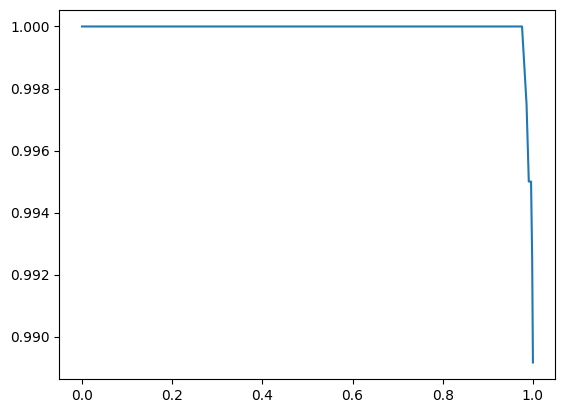

In [57]:
n = 100
tresh = np.array(range(n+1))/10
list_precissions = []
list_recall = []
for val in tresh:
    list_precissions.append(mean_metric(iou_scores_list,
                                        func='precision',
                                        iou_treshold=val))
    list_recall.append(mean_metric(iou_scores_list,
                                   func='recall',
                                   iou_treshold=val))
print(list_recall)
print(list_precissions)
plt.plot(list_recall, list_precissions)


Определение Average Precision (AP):

In [43]:
import numpy as np
from sklearn.metrics import average_precision_score

def calculate_a(box_iou_list, iou_threshold):
    """
    Вычисляет метрику AP для списка тензоров коэффициентов IoU и порогового значения IoU.

    Параметры:
    - box_iou_list: список тензоров коэффициентов IoU размерности [N, M], где N и M - количество ограничивающих рамок.
    - iou_threshold: пороговое значение IoU, при котором детектированный объект считается правильно классифицированным.

    Возвращает:
    - ap: значение метрики AP для всех изображений в списке box_iou_list.
    """

    y_true = []
    y_scores = []
    for box_iou in box_iou_list:
        y_true.append(np.where(box_iou >= iou_threshold, 1, 0))
        y_scores.append(box_iou)
    y_true = np.concatenate(y_true, axis=None)
    y_scores = np.concatenate(y_scores, axis=None)

    return average_precision_score(y_true, y_scores)

In [45]:
#from metrics import calculate_ap
print('AP =', calculate_a(iou_scores_list, iou_threshold=0.1))

AP = 1.0


In [30]:
visualize_detection(val_dataset, model=model, idx=2)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [ ]:
# Реализация построения результата детекции тестовой картинки
treshold = 0.1  # Задалим порог. Если score больше порога, то выделяем бокс
plt.figure(figsize=(9, 7), dpi=80)
plt.title(f'test_image')
image = (test_im.copy() * 255).astype(np.uint8)
class_detect = ['none','person']

for i in range(preds[0]['boxes'].size()[0]):
        if float(preds[0]['scores'][i]) > treshold:
                [xmin, ymin, xmax, ymax] = preds[0]['boxes'][i]
                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                text = class_detect[int(preds[0]['labels'][i])] + ' ' + \
                  str(round(float(preds[0]['scores'][i]),2))
                image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                image = cv2.putText(image, text, (xmin, ymin - 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
plt.imshow(image)
plt.show()

---

## Детекция людей с каской с без:

С помощью вэб сервиса https://www.makesense.ai/ я самостоятельно разметил часть изображений, сделав на этот раз 2 отдельных класса - __человек с каской на голове__ и __человек без каски__. <br>
Датасет, содержащий новую аннотацию можно скачать по этой [ссылке](https://disk.yandex.ru/d/9fph4DZZbUc1bQ) <br>
Результирующие аннотации я сохранил в папке detect_hat_dataset/annotations <br><br>

Теперь добавим в пока еще пустую папку detect_hat_dataset/images изображения, соответсвующие данным аннотациям (отберем по совпадающему названию)

In [ ]:
# Создадаим пустую папку images:
newpath = 'detect_hat_dataset/images'
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
# Получим имена файлов аннотаций нового датасета без значения кодировки
names = []
for file in os.listdir('detect_hat_dataset/annotations'):
    names.append(file.split('.')[0])
print(f'Всего вручную размеченных фотографий {len(names)} штук')

Скопируем из папки detect_dataset/images подходящие фотки в папку detect_hat_dataset/images:

In [ ]:
for file in os.listdir('detect_dataset/images'):
    if file.split('.')[0] in names:
        shutil.copy2('detect_dataset/images/' + file, 'detect_hat_dataset/images')

Так как в данном случае изображений размеченных особенно мало, поэтому воспользуемся готовой функцией аугментации для увеличения размера датасета в 2 раза:

In [ ]:
aug(image_dir="detect_hat_dataset/images",
                  xml_dir="detect_hat_dataset/annotations",
                  out_folder='augmented_hat_dataset')

Теперь у нас есть папка augmented_hat_dataset с которой мы и будем работать при обучении сети

---